In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install ultralytics opencv-python tensorflow matplotlib


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from ultralytics import YOLO
from google.colab import files
import os


In [ ]:
# Folder utama model di Drive
BASE_DIR = "/content/drive/MyDrive/pothole_detection_model"

# Model paths
YOLO_PT_PATH = os.path.join(BASE_DIR, "weights/best.pt")
TFLITE_PATH = os.path.join(BASE_DIR, "best_float32.tflite")

# Image test (bebas ganti)
IMAGE_PATH = os.path.join(BASE_DIR, "test.jpg")


In [ ]:
uploaded = files.upload()
uploaded_file = list(uploaded.keys())[0]

print("Uploaded file:", uploaded_file)


Saving images.jpeg to images (3).jpeg
Uploaded file: images (3).jpeg


In [ ]:
SAVE_DIR = "/content/drive/MyDrive/uploads"
os.makedirs(SAVE_DIR, exist_ok=True)

SAVE_PATH = os.path.join(SAVE_DIR, uploaded_file)

with open(SAVE_PATH, "wb") as f:
    f.write(uploaded[uploaded_file])

print("File disimpan di:", SAVE_PATH)


File disimpan di: /content/drive/MyDrive/uploads/images (3).jpeg


In [ ]:
def load_image(path):
    img = cv2.imread(path)
    if img is None:
        raise ValueError("Gambar tidak bisa dibaca")
    return img, cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


In [ ]:
YOLO_PT_PATH = "/content/drive/MyDrive/pothole_detection_model/weights/best.pt"
yolo_model = YOLO(YOLO_PT_PATH)


# Export Model ke INT8 TFLite (Untuk Realtime Android)
Ini akan convert model ke int8 quantized yang 3-4x lebih cepat

In [ ]:
# Export model ke int8 TFLite (quantized untuk speed)
yolo_model.export(
    format='tflite',
    imgsz=640,
    int8=True,  # Enable int8 quantization (3-4x faster!)
)

# File akan tersimpan otomatis di folder yang sama dengan best.pt
# Path: /content/drive/MyDrive/pothole_detection_model/weights/best_saved_model/best_int8.tflite

print("✅ Model int8 berhasil di-export!")
print("📁 File tersimpan di: best_saved_model/best_int8.tflite")


# Test INT8 Model
Tes apakah model int8 tetap akurat

In [ ]:
# Load int8 model untuk testing
# File ada di folder weights/best_saved_model/ setelah export
TFLITE_INT8_PATH = "/content/drive/MyDrive/pothole_detection_model/weights/best_saved_model/best_int8.tflite"

interpreter_int8 = tf.lite.Interpreter(model_path=TFLITE_INT8_PATH)
interpreter_int8.allocate_tensors()

input_details_int8 = interpreter_int8.get_input_details()
output_details_int8 = interpreter_int8.get_output_details()

print("✅ INT8 model loaded!")
print("Input shape:", input_details_int8[0]['shape'])
print("Output shape:", output_details_int8[0]['shape'])


In [ ]:
def preprocess_tflite(img):
    img = cv2.resize(img, (640, 640))
    img = img / 255.0
    return img.astype(np.float32)[None, ...]


In [ ]:
# Load float32 model untuk comparison
TFLITE_FLOAT32_PATH = "/content/drive/MyDrive/pothole_detection_model/best_float32.tflite"

interpreter = tf.lite.Interpreter(model_path=TFLITE_FLOAT32_PATH)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("✅ FLOAT32 model loaded!")


In [ ]:
# Test inference int8 vs float32 (compare speed & accuracy) - WITH WARMUP
import time

img, img_rgb = load_image(SAVE_PATH)
img_input = preprocess_tflite(img)

print("🔥 Warming up models...")
# Warmup runs (cold start)
for _ in range(3):
    interpreter.set_tensor(input_details[0]['index'], img_input)
    interpreter.invoke()
    interpreter_int8.set_tensor(input_details_int8[0]['index'], img_input)
    interpreter_int8.invoke()
print("✅ Warmup complete!\n")

# Benchmark: Run 5x dan ambil average
print("⏱️  Running benchmarks (5 iterations each)...\n")

times_f32 = []
times_i8 = []

for i in range(5):
    # Test FLOAT32
    start = time.time()
    interpreter.set_tensor(input_details[0]['index'], img_input)
    interpreter.invoke()
    output_float32 = interpreter.get_tensor(output_details[0]['index'])
    times_f32.append((time.time() - start) * 1000)
    
    # Test INT8
    start = time.time()
    interpreter_int8.set_tensor(input_details_int8[0]['index'], img_input)
    interpreter_int8.invoke()
    output_int8 = interpreter_int8.get_tensor(output_details_int8[0]['index'])
    times_i8.append((time.time() - start) * 1000)
    
    print(f"Run {i+1}: FLOAT32={times_f32[-1]:.1f}ms | INT8={times_i8[-1]:.1f}ms")

# Calculate averages
avg_f32 = sum(times_f32) / len(times_f32)
avg_i8 = sum(times_i8) / len(times_i8)

print("\n" + "="*60)
print("📊 BENCHMARK RESULTS (Average of 5 runs)")
print("="*60)
print(f"⏱️  FLOAT32: {avg_f32:.1f}ms")
print(f"⏱️  INT8:    {avg_i8:.1f}ms")
print(f"🚀 Speedup: {avg_f32/avg_i8:.2f}x faster with INT8")
print(f"⏰ Time saved: {avg_f32 - avg_i8:.1f}ms per frame")
print("="*60)

# Compare detections
detections_f32 = (output_float32[0].T[:, 4] > 0.25).sum()
detections_i8 = (output_int8[0].T[:, 4] > 0.25).sum()
print(f"🎯 Float32 detections: {detections_f32}")
print(f"🎯 Int8 detections: {detections_i8}")

print("\n💡 Estimasi FPS di mobile (asumsi 2x lebih lambat dari Colab):")
mobile_f32_fps = 1000 / (avg_f32 * 2)
mobile_i8_fps = 1000 / (avg_i8 * 2)
print(f"   - FLOAT32: ~{mobile_f32_fps:.1f} FPS")
print(f"   - INT8:    ~{mobile_i8_fps:.1f} FPS")


# Visualisasi Deteksi INT8 Model
Compare hasil deteksi dan processing time antara FLOAT32 vs INT8

In [ ]:
# Visualisasi FLOAT32 vs INT8 side by side dengan timing
import time

img, img_rgb_f32 = load_image(SAVE_PATH)
img, img_rgb_i8 = load_image(SAVE_PATH)

h, w, _ = img_rgb_f32.shape
CONF_THRES = 0.25

# Process FLOAT32
img_input = preprocess_tflite(img)
start = time.time()
interpreter.set_tensor(input_details[0]['index'], img_input)
interpreter.invoke()
output_f32 = interpreter.get_tensor(output_details[0]['index'])
time_f32_ms = (time.time() - start) * 1000

detections_f32 = output_f32[0].T
count_f32 = 0
for det in detections_f32:
    cx, cy, bw, bh, conf = det
    if conf < CONF_THRES:
        continue
    
    count_f32 += 1
    x1 = int((cx - bw / 2) * w / 640)
    y1 = int((cy - bh / 2) * h / 640)
    x2 = int((cx + bw / 2) * w / 640)
    y2 = int((cy + bh / 2) * h / 640)
    
    cv2.rectangle(img_rgb_f32, (x1, y1), (x2, y2), (255,0,0), 2)
    cv2.putText(img_rgb_f32, f"{conf:.2f}", (x1, y1-10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)

# Process INT8
start = time.time()
interpreter_int8.set_tensor(input_details_int8[0]['index'], img_input)
interpreter_int8.invoke()
output_i8 = interpreter_int8.get_tensor(output_details_int8[0]['index'])
time_i8_ms = (time.time() - start) * 1000

detections_i8 = output_i8[0].T
count_i8 = 0
for det in detections_i8:
    cx, cy, bw, bh, conf = det
    if conf < CONF_THRES:
        continue
    
    count_i8 += 1
    x1 = int((cx - bw / 2) * w / 640)
    y1 = int((cy - bh / 2) * h / 640)
    x2 = int((cx + bw / 2) * w / 640)
    y2 = int((cy + bh / 2) * h / 640)
    
    cv2.rectangle(img_rgb_i8, (x1, y1), (x2, y2), (0,255,0), 2)
    cv2.putText(img_rgb_i8, f"{conf:.2f}", (x1, y1-10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)

# Display side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].imshow(img_rgb_f32)
axes[0].set_title(f"FLOAT32 Model\n⏱️ {time_f32_ms:.1f}ms | 🎯 {count_f32} detections", 
                  fontsize=14, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(img_rgb_i8)
axes[1].set_title(f"INT8 Model\n⏱️ {time_i8_ms:.1f}ms | 🎯 {count_i8} detections", 
                  fontsize=14, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Summary
print("\n" + "="*60)
print("📊 PERFORMANCE SUMMARY")
print("="*60)
print(f"FLOAT32: {time_f32_ms:.1f}ms ({count_f32} detections)")
print(f"INT8:    {time_i8_ms:.1f}ms ({count_i8} detections)")
print(f"🚀 Speedup: {time_f32_ms/time_i8_ms:.2f}x faster with INT8")
print(f"⏰ Time saved: {time_f32_ms - time_i8_ms:.1f}ms per frame")
print("="*60)
print(f"\n💡 Estimasi FPS di mobile:")
print(f"   - FLOAT32: ~{1000/time_f32_ms:.1f} FPS")
print(f"   - INT8:    ~{1000/time_i8_ms:.1f} FPS")



image 1/1 /content/drive/MyDrive/uploads/images (3).jpeg: 960x1280 1 item, 12750.4ms
Speed: 52.6ms preprocess, 12750.4ms inference, 1.4ms postprocess per image at shape (1, 3, 960, 1280)


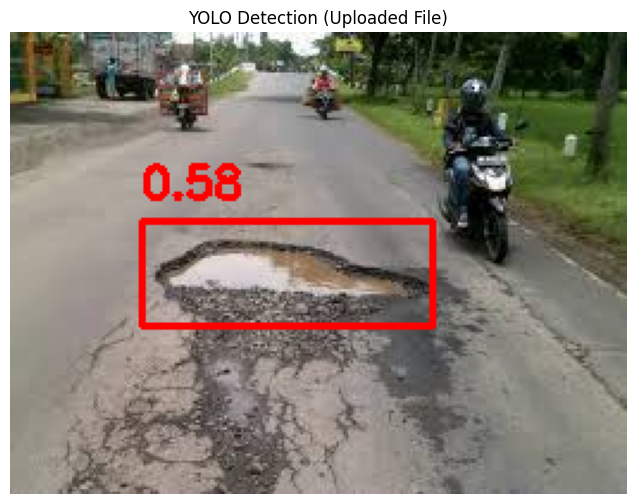

In [ ]:
img, img_rgb = load_image(SAVE_PATH)

results = yolo_model(SAVE_PATH, conf=0.25)

for box in results[0].boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0])
    conf = box.conf[0].item()

    cv2.rectangle(img_rgb, (x1,y1), (x2,y2), (255,0,0), 2)
    cv2.putText(img_rgb, f"{conf:.2f}", (x1, y1-10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,0,0), 2)

plt.figure(figsize=(8,6))
plt.imshow(img_rgb)
plt.axis("off")
plt.title("YOLO Detection (Uploaded File)")
plt.show()
